Let's import some dependencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.constants import h,k,c
from scipy.optimize import curve_fit, brute, minimize
from astropy import units as u
#from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
import time
import emcee
from pprint import pprint
print(emcee.__version__)
import warnings

%matplotlib notebook

2.2.1


Now some global variables that we'll need: the Gaia zero points, and the filter zero points and central wavelengths for all our filters.

In [2]:
G_ZP_Vega = 25.6883657251
GBp_ZP_Vega = 25.3513881707
GRp_ZP_Vega = 24.7619199882
        
G_ZP_AB = 25.7933969562
GBp_ZP_AB = 25.3805596387
GRp_ZP_AB = 25.1161276701
        
G_f0_AB = 10.**(0.4*G_ZP_AB)
GBp_f0_AB = 10.**(0.4*GBp_ZP_AB)
GRp_f0_AB = 10.**(0.4*GRp_ZP_AB)
        
G_Jy_per_photon = 3631./G_f0_AB
GBp_Jy_per_photon = 3631./GBp_f0_AB
GRp_Jy_per_photon = 3631./GRp_f0_AB
        
G_f0_Vega_photon = 10.**(0.4*G_ZP_Vega)
GBp_f0_Vega_photon = 10.**(0.4*GBp_ZP_Vega)
GRp_f0_Vega_photon = 10.**(0.4*GRp_ZP_Vega)
        
G_f0_vega = G_Jy_per_photon * G_f0_Vega_photon
GBp_f0_vega = GBp_Jy_per_photon * GBp_f0_Vega_photon
GRp_f0_vega = GRp_Jy_per_photon * GRp_f0_Vega_photon

In [3]:
filterzps = {'gmag':G_f0_vega, 'bpmag':GBp_f0_vega, 'rpmag':GRp_f0_vega, 'jmag':1594., 'hmag':1024., 'kmag':666.7, 'w1mag':309.54, 'w2mag':171.787, 'w3mag':31.674, 'w4mag':8.363}
filtercentwav = {'gmag':0.673, 'bpmag':0.532, 'rpmag':0.797, 'jmag':1.235, 'hmag':1.662, 'kmag':2.159, 'w1mag':3.35, 'w2mag':4.60, 'w3mag':11.56, 'w4mag':22.08}

A function that will get nuFnu for all our filters.

In [4]:
def get_nuFnu(filtername, magnitude, magerr):
    zp = filterzps[filtername]
    centwav = filtercentwav[filtername]

    if magnitude == None:
        return None, None, centwav

    flux = zp*(10.**(-0.4*magnitude))
    fluxerr = flux * np.log(10.) * 0.4 * magerr
    
    #Convert to ergs/s/cm**2/Hz
    flux_use = flux*1.0e-23
    fluxerr_use = fluxerr*1.0e-23
    
    #print(magnitude, magerr, flux_use, fluxerr_use)
    
    #Get nuFnu
    centwav_meters = centwav*1.0e-6
    centwav_Hz = c/centwav_meters
    nuFnu = centwav_Hz * flux_use
    nuFnu_err = centwav_Hz * fluxerr_use
    return nuFnu, nuFnu_err, centwav

The FullSystem class

In [5]:
class FullSystem:
    #Class for FullSubject object containing all data on a given target
    
    def __init__(self, infodict):
        '''Input: vec from DD database output
        
        Purpose: read data from DD database, calculate fluxes for each filter, get nuFnu, initialize spaces for 
        fit parameters'''
        
        #Read data in from vector
        self.zooniverse_id = infodict['ZooID']
        self.wiseid = infodict['wiseid']
        self.ra = float(infodict['ra'])
        self.dec = float(infodict['dec'])
        #self.glong = float(vec[9])
        #self.glat = float(vec[10])

        self.jmag = float(infodict['jmag'])
        self.jmagerr = float(infodict['jmagerr'])
        self.hmag = float(infodict['hmag'])
        self.hmagerr = float(infodict['hmagerr'])
        self.kmag = float(infodict['kmag'])
        self.kmagerr = float(infodict['kmagerr'])
        tempw1mag = float(infodict['w1mag'])
        tempw1magerr = float(infodict['w1magerr'])
        tempw2mag = float(infodict['w2mag'])
        tempw2magerr = float(infodict['w2magerr'])
        self.w3mag = float(infodict['w3mag'])
        self.w3magerr = float(infodict['w3magerr'])
        self.w4mag = float(infodict['w4mag'])
        self.w4magerr = float(infodict['w4magerr'])
        
        #Correct W1 fluxes for saturation
        if tempw1mag > 8.:
            self.w1mag = tempw1mag + 0.
            self.w1magerr = tempw1magerr + 0.
        else:
            self.w1mag = tempw1mag + (0. - 0.1359 + (0.0396*tempw1mag) - (0.0023*tempw1mag*tempw1mag)) - 0.031
            self.w1magerr = (((1. + 0.0396 - (0.0046*tempw1mag))**2) * (tempw1magerr**2))**0.5
        
        #Correct W2 fluxes for saturation
        if tempw2mag > 6.7:
            self.w2mag = tempw2mag + 0.
            self.w2magerr = tempw2magerr + 0.
        elif tempw2mag > 5.4:
            self.w2mag = tempw2mag + (-0.3530 + (0.8826*tempw2mag) - (0.2380*(tempw2mag**2)) + (0.0170*(tempw2mag**3))) + 0.004
            self.w2magerr = (((1. + 0.8826 - (0.4760 * tempw2mag) + (0.0510 * (tempw2mag**2)))**2) * (tempw2magerr**2))**0.5
        else:
            self.w2mag = tempw2mag + (1.5777 - (0.3495*tempw2mag) + (0.0160*(tempw2mag**2))) + 0.004
            self.w2magerr = (((1. - 0.3495 + (2.*0.0160*tempw2mag))**2) * (tempw2magerr**2))**0.5
        
        self.sourcedict = infodict
        
        self.gmag1 = infodict['gmag1']
        self.gmagerr1 = infodict['gmagerr1']*5.
        
        self.gmag2 = infodict['gmag2']
        self.gmagerr2 = infodict['gmagerr2']*5.

        self.use_gaia1 = False
        self.use_gaia2 = False
        #self.use_Johnson = False
        
        if ('bpmag1' in infodict.keys()):
            self.bpmag1 = infodict['bpmag1']
            self.bpmagerr1 = infodict['bpmagerr1']*5.
            self.rpmag1 = infodict['rpmag1']
            self.rpmagerr1 = infodict['rpmagerr1']*5.
            self.use_gaia1 = True
        else:
            self.bpmag1 = None
            self.bpmagerr1 = None
            self.rpmag1 = None
            self.rpmagerr1 = None
            
        if ('bpmag2' in infodict.keys()):
            self.bpmag2 = infodict['bpmag2']
            self.bpmagerr2 = infodict['bpmagerr2']*5.
            self.rpmag2 = infodict['rpmag2']
            self.rpmagerr2 = infodict['rpmagerr2']*5.
            self.use_gaia2 = True
        else:
            self.bpmag2 = None
            self.bpmagerr2 = None
            self.rpmag2 = None
            self.rpmagerr2 = None
            
        self.mags = {'jmag':self.jmag,'hmag':self.hmag,'kmag':self.kmag,'w1mag':self.w1mag,'w2mag':self.w2mag,
                      'w3mag':self.w3mag,'w4mag':self.w4mag,'gmag1':self.gmag1,'gmag2':self.gmag2,'bpmag1':self.bpmag1,
                      'rpmag1':self.rpmag1,'bpmag2':self.bpmag2,'rpmag2':self.rpmag2}

        self.magerrs = {'jmag':self.jmagerr,'hmag':self.hmagerr,'kmag':self.kmagerr,'w1mag':self.w1magerr,
                         'w2mag':self.w2magerr,'w3mag':self.w3magerr,'w4mag':self.w4magerr,'gmag1':self.gmagerr1,
                         'gmag2':self.gmagerr2,'bpmag1':self.bpmagerr1,'rpmag1':self.rpmagerr1,'bpmag2':self.bpmagerr2,
                         'rpmag2':self.rpmagerr2}

        
        filters = ['gmag1','bpmag1','rpmag1','gmag2','bpmag2','rpmag2','jmag','hmag','kmag','w1mag','w2mag','w3mag','w4mag']
        
        self.filters_used = [x for x in filters if (self.mags[x] != None)]
        
        self.nuFnus = {}
        self.nuFnuerrs = {}
        self.centwav_microns = {}
        
        centwav_list = []
        nuFnu_list = []
        nuFnuerr_list = []
        
        centwav_list1 = []
        nuFnu_list1 = []
        nuFnuerr_list1 = []
        
        centwav_list2 = []
        nuFnu_list2 = []
        nuFnuerr_list2 = []

        centwav_listcombined = []
        nuFnu_listcombined = []
        nuFnuerr_listcombined = []

        
        for filt in filters:
            if filt[-1] != 'g':
                filt_use = filt[:-1]
            else:
                filt_use = filt
            nuFnu, nuFnu_err, centwav= get_nuFnu(filt_use, self.mags[filt], self.magerrs[filt])
            self.nuFnus.update({filt:nuFnu})
            self.nuFnuerrs.update({filt:nuFnu_err})
            self.centwav_microns.update({filt:centwav})
            if nuFnu == None:
                continue
            centwav_list.append(centwav)
            nuFnu_list.append(nuFnu)
            nuFnuerr_list.append(nuFnu_err)
            if filt[-1] == '1':
                centwav_list1.append(centwav)
                nuFnu_list1.append(nuFnu)
                nuFnuerr_list1.append(nuFnu_err)
            elif filt[-1] == '2':
                centwav_list2.append(centwav)
                nuFnu_list2.append(nuFnu)
                nuFnuerr_list2.append(nuFnu_err)
            else:
                centwav_listcombined.append(centwav)
                nuFnu_listcombined.append(nuFnu)
                nuFnuerr_listcombined.append(nuFnu_err)
        
        self.centwav_vec = np.array(centwav_list)
        self.nuFnu_vec = np.array(nuFnu_list)
        self.nuFnuerr_vec = np.array(nuFnuerr_list)
        
        self.centwav_vec1 = np.array(centwav_list1)
        self.nuFnu_vec1 = np.array(nuFnu_list1)
        self.nuFnuerr_vec1 = np.array(nuFnuerr_list1)
        
        self.centwav_vec2 = np.array(centwav_list2)
        self.nuFnu_vec2 = np.array(nuFnu_list2)
        self.nuFnuerr_vec2 = np.array(nuFnuerr_list2)
        
        self.centwav_vec_combined = np.array(centwav_listcombined)
        self.nuFnu_vec_combined = np.array(nuFnu_listcombined)
        self.nuFnuerr_vec_combined = np.array(nuFnuerr_listcombined)        
        
        
        #Set up vector for calculating fluxes from magnitudes
        #if (self.use_Johnson and self.use_gaia):
        #    self.mags_to_use_temp = [self.gaia_gmag, self.gaia_bpmag, self.gaia_rpmag, self.Bmag, self.Vmag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
        #    self.magerrs_to_use_temp = [self.gaia_gmagerr, self.gaia_bpmagerr, self.gaia_rpmagerr, self.Bmagerr, self.Vmagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
        #    self.filterzps_to_use_temp = filterzps
        #    self.filtercentwav_to_use_temp = filtercentwav
        #    self.filts_to_use_temp = filternames
        
        #if (not self.use_Johnson):
        #    self.mags_to_use_temp = [self.gaia_gmag, self.gaia_bpmag, self.gaia_rpmag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
        #    self.magerrs_to_use_temp = [self.gaia_gmagerr, self.gaia_bpmagerr, self.gaia_rpmagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
        #    self.filterzps_to_use_temp = filterzps_noJohnson
        #    self.filtercentwav_to_use_temp = filtercentwav_noJohnson
        #    self.filts_to_use_temp = filternames_noJohnson

        #if (not self.use_gaia):
        #    self.mags_to_use_temp = [self.gaia_gmag, self.Bmag, self.Vmag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
        #    self.magerrs_to_use_temp = [self.gaia_gmagerr, self.Bmagerr, self.Vmagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
        #    self.filterzps_to_use_temp = filterzps_nogaia
        #    self.filtercentwav_to_use_temp = filtercentwav_nogaia
        #    self.filts_to_use_temp = filternames_nogaia


            
        #print self.filts_to_use_temp

        
        #self.filts_to_use = np.array(self.filts_to_use_temp)
        #self.mags_to_use = np.array(self.mags_to_use_temp)
        #self.magerrs_to_use = np.array(self.magerrs_to_use_temp)
        
        #self.fluxes_to_use_temp = []
        #self.fluxerrs_to_use_temp = []
        
        #Convert to janskys
        #for i in range(len(self.filterzps_to_use_temp)):
        #    self.fluxes_to_use_temp.append(self.filterzps_to_use_temp[i] * 10.**(-0.4*self.mags_to_use[i]))
        #    self.fluxerrs_to_use_temp.append(self.fluxes_to_use_temp[-1] * np.log(10) * 0.4 * self.magerrs_to_use[i])
        
        #Convert to ergs/s/cm**2/Hz
        #self.fluxes_to_use = np.array(self.fluxes_to_use_temp) * 1.e-23
        #self.fluxerrs_to_use = np.array(self.fluxerrs_to_use_temp) * 1.e-23
        
        #Get wavelengths, calculate nuFnu
        #self.centwavs_microns_to_use = np.array(self.filtercentwav_to_use_temp)
        #self.centwavs_meters_to_use = self.centwavs_microns_to_use * 1.e-6
        #self.centwavs_Hz_to_use = c/self.centwavs_meters_to_use
        #self.nuFnu_to_use = self.centwavs_Hz_to_use * self.fluxes_to_use
        #self.nuFnuerrs_to_use = self.centwavs_Hz_to_use * self.fluxerrs_to_use
        #self.filterzps_to_use = np.array(self.filterzps_to_use_temp)
        #self.filts_to_use = np.array(self.filts_to_use_temp)
        
        #self.centwavs_microns = self.centwavs_microns_long[-7:]
        #self.centwavs_meters = self.centwavs_microns * 1.e-6
        #self.centwavs_Hz = c/self.centwavs_meters
        #self.mags = self.mags_long[-7:]
        #self.magerrs = self.magerrs_long[-7:]
        #self.nuFnu = self.nuFnu_long[-7:]
        #self.nuFnuerrs = self.nuFnuerrs_long[-7:]

        #self.centwavs_microns_optical = self.centwavs_microns_long[5:]
        #self.centwavs_meters_optical = self.centwavs_microns_optical * 1.e-6
            
        #Initialize fit parameters
        self.Teff1 = None
        self.Teff1_err_low = None
        self.Teff1_err_high = None
        self.logg1 = None
        self.logg1_err_low = None
        self.logg1_err_high = None
        self.rdstar1 = None
        self.rdstar1_err_low = None
        self.rdstar1_err_high = None

        self.Teff2 = None
        self.Teff2_err_low = None
        self.Teff2_err_high = None
        self.logg2 = None
        self.logg2_err_low = None
        self.logg2_err_high = None
        self.rdstar2 = None
        self.rdstar2_err_low = None
        self.rdstar2_err_high = None
        
        self.Tdisk = None
        self.Tdisk_err_low = None
        self.Tdisk_err_high = None
        self.xdisk = None
        self.xdisk_err_low = None
        self.xdisk_err_high = None
        self.fir = None
        self.fir_err_low = None
        self.fir_err_high = None
        
        self.nuFnu_star1 = None
        self.nuFnu_star2 = None
        self.nuFnu_disk = None
        
        self.nuFnu_star1_plotting_temp = None
        self.nuFnu_star2_plotting_temp = None
        self.nuFnu_disk_plotting_temp = None
        #self.nuFnu_disk1_plotting_temp = None
        #self.nuFnu_disk2_plotting_temp = None
        self.nuFnu_model_plotting_temp = None

        #self.nuFnu_disk_plotting_temp_powerlaw = None
        #self.nuFnu_model_plotting_temp_powerlaw = None
        #self.nuFnu_disk_plotting_temp_blackbody = None
        #self.nuFnu_model_plotting_temp_blackbody = None
        
        self.nuFnu_star1_plotting = None
        self.nuFnu_star2_plotting = None
        self.nuFnu_disk_plotting = None
        self.nuFnu_model_plotting = None        
        
        self.sig_disk = None
        self.num_excesses = None
        
        self.good_star_fit = False
        self.good_disk_fit = False
        
        self.chistar = None
        self.chidisk = None
        
        self.fitfail = False
        
        self.use_models = False
        
        #self.log10Teffguess = None
        #self.log10rdstarguess = None
        self.Teff1guess = None
        self.logg1_guess = None
        self.log10rdstar1_guess = None
        self.Teff2guess = None
        self.logg2_guess = None
        self.log10rdstar2_guess = None  

        self.log10Tdiskguess = None
        self.log10xdiskguess = None
        
        self.filter_cut = None
        self.sampler = None
        
        #self.powerlaw = False
        #self.alpha = None
        #self.log10beta = None
        #self.beta = None
        
        #self.alpha_err_low = None
        #self.alpha_err_high = None
        
        #self.beta_err_low = None
        #self.beta_err_high = None
        
        #self.alpha_guess = None
        #self.log10beta_guess = None
        #self.beta_guess = None

    def __str__(self):
        s = ''
        for entry in self.sourcevec:
            s = s + str(entry) + ','

        s = s[:-1]

        return s
    
    
print("Class read in")

Class read in


In [6]:
def plot_fluxdata(subj):
    fig = plt.figure()
    plt.errorbar(subj.centwav_vec1, subj.nuFnu_vec1, yerr=5.*subj.nuFnuerr_vec1,fmt='.')
    plt.errorbar(subj.centwav_vec2, subj.nuFnu_vec2, yerr=5.*subj.nuFnuerr_vec2,fmt='.')
    plt.errorbar(subj.centwav_vec_combined, subj.nuFnu_vec_combined, yerr=5.*subj.nuFnuerr_vec_combined,fmt='.')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Wavelength ($\mu$m)')
    plt.ylabel(r'Flux')
    plt.xlim([0.4,250.])

    min_nuFnu_logs = min(np.log10(subj.nuFnu_vec))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_vec))

    ymin = (float(np.floor((min_nuFnu_logs-0.5)*2.))/2.)
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.
    print(ymin,ymax)

    plt.ylim([10**ymin,10**ymax])
    
    return fig

In [7]:
def fluxdrive_plot(spectname, binsize):
    spec_X, spec_S, spec_dict = import_spectrum(spectname, binsize)
    return spec_X, spec_S, spec_dict

def import_spectrum(spectname, binsize):
    spect_Xlist = []
    spect_Slist = []
    spect_dict = {}
    
    with open(spectname) as f:
        spectfilelist = f.readlines()
        
    testline = spectfilelist[0]
    test_res = [pos for pos, char in enumerate(testline) if char == '-']
    line_start = testline.index('1')
    
    flag1 = False
    flag2 = False
    
    flag1 = (test_res[0] < (7 + line_start))
    flag2 = (test_res[1] > (20 + line_start))
    
    #print flag1, flag2
    
    for line in spectfilelist:
        if (flag1 and flag2):
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag1:
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag2:
            line_use = line[:25] + ' ' + line[25:]
        else:
            line_use = line
            
        datavec = line_use.split()
        xstr = datavec[0]
        sstr = datavec[1]
        sstr1 = sstr.replace('D','e')
        #print datavec
        #print sstr1
        
        x = float(xstr)
        s = float(sstr1)
        
        spect_Xlist.append(x)
        spect_Slist.append((10.**(s-8.)))
        spect_dict[x] = s
        
    spect_X_binned = []
    spect_S_binned = []
    
    #ents_per_bin = binsize*20.
    
    spect_X = np.array(spect_Xlist)
    spect_S = np.array(spect_Slist)
    
    return spect_X, spect_S, spect_dict

In [8]:
infodict_J0949 = {'wiseid':'J094900.65-713803.1','ZooID':'AWI00063nx','ra':(15.*(9.+(49./60.)+(00.65/3600.))),
                  'dec':(-1.*(71.+(38./60.)+(3.1/3600.))),'gmag1':13.8874,'bpmag1':14.9381,'rpmag1':12.4398,
                  'gmagerr1':0.0051,'bpmagerr1':0.0352,'rpmagerr1':0.0316,'gmag2':14.1849,'gmagerr2':0.0017,
                  'jmag':10.437,'hmag':9.858,'kmag':9.500,'jmagerr':0.033,'hmagerr':0.036,'kmagerr':0.024,'w1mag':9.248,
                  'w1magerr':0.022,'w2mag':9.005,'w2magerr':0.020,'w3mag':7.780,'w3magerr':0.016,'w4mag':6.360,
                  'w4magerr':0.037}

infodict_J0446 = {'wiseid':'J044634.16-262756.1','ZooID':'AWI000601p','ra':(15.*(4.+(46./60.)+(34.16/3600.))),
                  'dec':(-1.*(36.+(27./60.)+(56.1/3600.))),'gmag1':15.1256,'bpmag1':16.9497,'rpmag1':13.7936,
                  'gmagerr1':0.0011,'bpmagerr1':0.0288,'rpmagerr1':0.0038,'gmag2':14.9731,'gmagerr2':0.0006,
                  'bpmag2':16.6699,'rpmag2':13.6119,'bpmagerr2':0.0230,'rpmagerr2':0.0173,'jmag':10.437,'hmag':9.858,
                  'kmag':9.500,'jmagerr':0.033,'hmagerr':0.036,'kmagerr':0.024,'w1mag':9.248,'w1magerr':0.022,
                  'w2mag':9.005,'w2magerr':0.020,'w3mag':7.780,'w3magerr':0.016,'w4mag':6.360,'w4magerr':0.037}

In [9]:
subj_J0949 = FullSystem(infodict_J0949)
print('J0949 read in')
print(subj_J0949.filters_used)

subj_J0446 = FullSystem(infodict_J0446)
print('J0446 read in')

J0949 read in
['gmag1', 'bpmag1', 'rpmag1', 'gmag2', 'jmag', 'hmag', 'kmag', 'w1mag', 'w2mag', 'w3mag', 'w4mag']
J0446 read in


-12.0 -9.0


C:\Anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


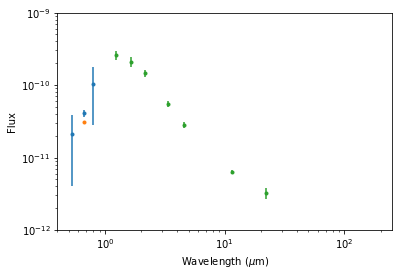

In [10]:
fluxplot_J0949 = plot_fluxdata(subj_J0949)
fluxplot_J0949.show()

Generate the dictionary of models, and from there the list of model combinations.

In [11]:
btsettl_df = pd.read_csv('btsettl_combo_readin_20190315.csv',low_memory=False)

In [12]:
btsettl_models_dict = {}
btsettl_models_combo_dict = {}

#print num_models
#btsettl_data = btsettl_df.values

keylist = []

combo_keylist = []

for i in range(440):
    entry = btsettl_df.loc[i,:]
    print(entry)
    if float(entry['Teff']) > 2400.:
    #print btsettl_data[i,0]
    #print btsettl_data[i,1]
    #print btsettl_data[i,2:]
        key = (float(entry['Teff']),float(entry['Logg']))
        keylist.append(key)

        btsettl_models_dict[key] = {'gmag':entry['G2018'],'bpmag':entry['G2018_BP'],'rpmag':entry['G2018_RP'],
                                   'jmag':entry['J'],'hmag':entry['H'],'kmag':entry['K'],'w1mag':entry['W1_W10'],
                                   'w2mag':entry['W2_W10'],'w3mag':entry['W3_W10'],'w4mag':entry['W4_W10']}
        
        pprint(btsettl_models_dict[key])

for key1 in keylist:
    for key2 in keylist:
        combo_keylist.append((key1,key2))
        
print(len(combo_keylist))

Teff        5777.000
Logg           4.440
G2018        -38.580
G2018_BP     -38.257
G2018_RP     -39.065
J            -39.567
H            -39.880
K            -39.952
W1_W10       -39.955
W2_W10       -39.939
W3_W10       -39.976
W4_W10       -39.981
Name: 0, dtype: float64
{'bpmag': -38.257,
 'gmag': -38.58,
 'hmag': -39.88,
 'jmag': -39.567,
 'kmag': -39.952,
 'rpmag': -39.065,
 'w1mag': -39.955,
 'w2mag': -39.939,
 'w3mag': -39.976,
 'w4mag': -39.981}
Teff        1200.000
Logg           3.500
G2018        -27.962
G2018_BP     -21.601
G2018_RP     -29.437
J            -33.280
H            -34.566
K            -35.012
W1_W10       -35.763
W2_W10       -35.946
W3_W10       -37.478
W4_W10       -37.688
Name: 1, dtype: float64
Teff        1200.000
Logg           4.500
G2018        -28.059
G2018_BP     -22.170
G2018_RP     -29.542
J            -33.293
H            -34.549
K            -34.983
W1_W10       -35.477
W2_W10       -36.093
W3_W10       -37.522
W4_W10       -37.687
Name: 2, dty

Name: 91, dtype: float64
Teff        2250.000
Logg           2.500
G2018        -31.564
G2018_BP     -27.452
G2018_RP     -32.984
J            -36.523
H            -37.062
K            -37.522
W1_W10       -37.817
W2_W10       -38.181
W3_W10       -38.617
W4_W10       -38.792
Name: 92, dtype: float64
Teff        2250.000
Logg           3.000
G2018        -31.694
G2018_BP     -27.582
G2018_RP     -33.113
J            -36.545
H            -37.105
K            -37.559
W1_W10       -37.845
W2_W10       -38.185
W3_W10       -38.619
W4_W10       -38.768
Name: 93, dtype: float64
Teff        2250.000
Logg           3.500
G2018        -31.725
G2018_BP     -27.640
G2018_RP     -33.143
J            -36.536
H            -37.121
K            -37.571
W1_W10       -37.862
W2_W10       -38.170
W3_W10       -38.609
W4_W10       -38.737
Name: 94, dtype: float64
Teff        2250.000
Logg           4.000
G2018        -31.772
G2018_BP     -27.724
G2018_RP     -33.194
J            -36.563
H            -37.1

{'bpmag': -31.443,
 'gmag': -33.87,
 'hmag': -38.435,
 'jmag': -37.635,
 'kmag': -38.606,
 'rpmag': -35.172,
 'w1mag': -38.579,
 'w2mag': -38.835,
 'w3mag': -39.005,
 'w4mag': -39.152}
Teff        3000.000
Logg           3.000
G2018        -34.029
G2018_BP     -31.665
G2018_RP     -35.322
J            -37.665
H            -38.349
K            -38.546
W1_W10       -38.577
W2_W10       -38.842
W3_W10       -39.012
W4_W10       -39.154
Name: 154, dtype: float64
{'bpmag': -31.665,
 'gmag': -34.029,
 'hmag': -38.349000000000004,
 'jmag': -37.665,
 'kmag': -38.546,
 'rpmag': -35.321999999999996,
 'w1mag': -38.577,
 'w2mag': -38.842,
 'w3mag': -39.012,
 'w4mag': -39.154}
Teff        3000.000
Logg           3.500
G2018        -34.187
G2018_BP     -31.943
G2018_RP     -35.463
J            -37.662
H            -38.256
K            -38.500
W1_W10       -38.604
W2_W10       -38.864
W3_W10       -39.036
W4_W10       -39.167
Name: 155, dtype: float64
{'bpmag': -31.943,
 'gmag': -34.187,
 'hmag': -38

Name: 193, dtype: float64
{'bpmag': -34.354,
 'gmag': -35.567,
 'hmag': -38.7,
 'jmag': -38.092,
 'kmag': -38.94,
 'rpmag': -36.61,
 'w1mag': -39.062,
 'w2mag': -39.203,
 'w3mag': -39.328,
 'w4mag': -39.411}
Teff        3500.000
Logg           5.500
G2018        -35.616
G2018_BP     -34.434
G2018_RP     -36.648
J            -38.098
H            -38.695
K            -38.933
W1_W10       -39.065
W2_W10       -39.198
W3_W10       -39.329
W4_W10       -39.408
Name: 194, dtype: float64
{'bpmag': -34.434,
 'gmag': -35.616,
 'hmag': -38.695,
 'jmag': -38.098,
 'kmag': -38.933,
 'rpmag': -36.648,
 'w1mag': -39.065,
 'w2mag': -39.198,
 'w3mag': -39.329,
 'w4mag': -39.408}
Teff        3600.000
Logg           2.500
G2018        -35.419
G2018_BP     -34.092
G2018_RP     -36.491
J            -38.134
H            -39.056
K            -39.264
W1_W10       -39.281
W2_W10       -39.256
W3_W10       -39.405
W4_W10       -39.454
Name: 195, dtype: float64
{'bpmag': -34.092,
 'gmag': -35.419000000000004,
 

 'hmag': -39.064,
 'jmag': -38.429,
 'kmag': -39.271,
 'rpmag': -37.238,
 'w1mag': -39.363,
 'w2mag': -39.399,
 'w3mag': -39.514,
 'w4mag': -39.556999999999995}
Teff        3900.000
Logg           5.500
G2018        -36.374
G2018_BP     -35.505
G2018_RP     -37.264
J            -38.427
H            -39.019
K            -39.236
W1_W10       -39.348
W2_W10       -39.400
W3_W10       -39.518
W4_W10       -39.564
Name: 222, dtype: float64
{'bpmag': -35.505,
 'gmag': -36.374,
 'hmag': -39.019,
 'jmag': -38.427,
 'kmag': -39.236,
 'rpmag': -37.264,
 'w1mag': -39.348,
 'w2mag': -39.4,
 'w3mag': -39.518,
 'w4mag': -39.564}
Teff        4000.000
Logg           2.500
G2018        -36.407
G2018_BP     -35.599
G2018_RP     -37.250
J            -38.459
H            -39.259
K            -39.436
W1_W10       -39.477
W2_W10       -39.398
W3_W10       -39.544
W4_W10       -39.563
Name: 223, dtype: float64
{'bpmag': -35.599000000000004,
 'gmag': -36.407,
 'hmag': -39.259,
 'jmag': -38.459,
 'kmag': -39.4

 'w4mag': -39.673}
Teff        4400.000
Logg           4.000
G2018        -37.095
G2018_BP     -36.459
G2018_RP     -37.842
J            -38.798
H            -39.462
K            -39.593
W1_W10       -39.620
W2_W10       -39.558
W3_W10       -39.663
W4_W10       -39.676
Name: 254, dtype: float64
{'bpmag': -36.459,
 'gmag': -37.095,
 'hmag': -39.461999999999996,
 'jmag': -38.798,
 'kmag': -39.593,
 'rpmag': -37.842,
 'w1mag': -39.62,
 'w2mag': -39.558,
 'w3mag': -39.663000000000004,
 'w4mag': -39.676}
Teff        4400.000
Logg           4.500
G2018        -37.093
G2018_BP     -36.446
G2018_RP     -37.848
J            -38.805
H            -39.468
K            -39.598
W1_W10       -39.621
W2_W10       -39.562
W3_W10       -39.664
W4_W10       -39.678
Name: 255, dtype: float64
{'bpmag': -36.446,
 'gmag': -37.093,
 'hmag': -39.468,
 'jmag': -38.805,
 'kmag': -39.598,
 'rpmag': -37.848,
 'w1mag': -39.621,
 'w2mag': -39.562,
 'w3mag': -39.664,
 'w4mag': -39.678000000000004}
Teff        4400.0

 'jmag': -39.126999999999995,
 'kmag': -39.736,
 'rpmag': -38.371,
 'w1mag': -39.755,
 'w2mag': -39.708,
 'w3mag': -39.785,
 'w4mag': -39.794000000000004}
Teff        4900.000
Logg           4.500
G2018        -37.740
G2018_BP     -37.253
G2018_RP     -38.375
J            -39.130
H            -39.640
K            -39.742
W1_W10       -39.758
W2_W10       -39.712
W3_W10       -39.786
W4_W10       -39.795
Name: 290, dtype: float64
{'bpmag': -37.253,
 'gmag': -37.74,
 'hmag': -39.64,
 'jmag': -39.13,
 'kmag': -39.742,
 'rpmag': -38.375,
 'w1mag': -39.758,
 'w2mag': -39.711999999999996,
 'w3mag': -39.786,
 'w4mag': -39.795}
Teff        4900.000
Logg           5.000
G2018        -37.743
G2018_BP     -37.248
G2018_RP     -38.384
J            -39.136
H            -39.646
K            -39.748
W1_W10       -39.762
W2_W10       -39.716
W3_W10       -39.786
W4_W10       -39.796
Name: 291, dtype: float64
{'bpmag': -37.248000000000005,
 'gmag': -37.743,
 'hmag': -39.646,
 'jmag': -39.13599999999999

 'kmag': -39.855,
 'rpmag': -38.786,
 'w1mag': -39.865,
 'w2mag': -39.835,
 'w3mag': -39.89,
 'w4mag': -39.898}
Teff        5400.000
Logg           4.000
G2018        -38.253
G2018_BP     -37.873
G2018_RP     -38.792
J            -39.394
H            -39.779
K            -39.863
W1_W10       -39.871
W2_W10       -39.839
W3_W10       -39.892
W4_W10       -39.900
Name: 324, dtype: float64
{'bpmag': -37.873000000000005,
 'gmag': -38.253,
 'hmag': -39.779,
 'jmag': -39.394,
 'kmag': -39.863,
 'rpmag': -38.792,
 'w1mag': -39.871,
 'w2mag': -39.839,
 'w3mag': -39.891999999999996,
 'w4mag': -39.9}
Teff        5400.000
Logg           4.500
G2018        -38.253
G2018_BP     -37.871
G2018_RP     -38.795
J            -39.396
H            -39.786
K            -39.868
W1_W10       -39.874
W2_W10       -39.843
W3_W10       -39.893
W4_W10       -39.900
Name: 325, dtype: float64
{'bpmag': -37.871,
 'gmag': -38.253,
 'hmag': -39.786,
 'jmag': -39.396,
 'kmag': -39.868,
 'rpmag': -38.795,
 'w1mag': -39.

 'kmag': -39.961,
 'rpmag': -39.134,
 'w1mag': -39.965,
 'w2mag': -39.954,
 'w3mag': -39.985,
 'w4mag': -39.991}
Teff        5900.000
Logg           3.500
G2018        -38.677
G2018_BP     -38.378
G2018_RP     -39.135
J            -39.611
H            -39.897
K            -39.969
W1_W10       -39.970
W2_W10       -39.957
W3_W10       -39.988
W4_W10       -39.994
Name: 358, dtype: float64
{'bpmag': -38.378,
 'gmag': -38.677,
 'hmag': -39.897,
 'jmag': -39.611,
 'kmag': -39.969,
 'rpmag': -39.135,
 'w1mag': -39.97,
 'w2mag': -39.957,
 'w3mag': -39.988,
 'w4mag': -39.994}
Teff        5900.000
Logg           4.000
G2018        -38.679
G2018_BP     -38.379
G2018_RP     -39.139
J            -39.615
H            -39.906
K            -39.976
W1_W10       -39.975
W2_W10       -39.961
W3_W10       -39.991
W4_W10       -39.996
Name: 359, dtype: float64
{'bpmag': -38.379,
 'gmag': -38.679,
 'hmag': -39.906,
 'jmag': -39.615,
 'kmag': -39.976,
 'rpmag': -39.139,
 'w1mag': -39.975,
 'w2mag': -39.961

 'w4mag': -40.109}
Teff        6500.000
Logg           5.000
G2018        -39.108
G2018_BP     -38.882
G2018_RP     -39.488
J            -39.841
H            -40.053
K            -40.108
W1_W10       -40.097
W2_W10       -40.094
W3_W10       -40.102
W4_W10       -40.105
Name: 403, dtype: float64
{'bpmag': -38.882,
 'gmag': -39.108000000000004,
 'hmag': -40.053000000000004,
 'jmag': -39.841,
 'kmag': -40.108000000000004,
 'rpmag': -39.488,
 'w1mag': -40.097,
 'w2mag': -40.094,
 'w3mag': -40.102,
 'w4mag': -40.105}
Teff        6500.000
Logg           5.500
G2018        -39.109
G2018_BP     -38.880
G2018_RP     -39.494
J            -39.845
H            -40.061
K            -40.115
W1_W10       -40.103
W2_W10       -40.096
W3_W10       -40.102
W4_W10       -40.105
Name: 404, dtype: float64
{'bpmag': -38.88,
 'gmag': -39.109,
 'hmag': -40.061,
 'jmag': -39.845,
 'kmag': -40.115,
 'rpmag': -39.494,
 'w1mag': -40.103,
 'w2mag': -40.096,
 'w3mag': -40.102,
 'w4mag': -40.105}
Teff        6600.0

 'w1mag': -40.154,
 'w2mag': -40.15,
 'w3mag': -40.15,
 'w4mag': -40.152}
Teff        6900.000
Logg           2.500
G2018        -39.396
G2018_BP     -39.233
G2018_RP     -39.670
J            -39.940
H            -40.066
K            -40.129
W1_W10       -40.128
W2_W10       -40.133
W3_W10       -40.118
W4_W10       -40.094
Name: 426, dtype: float64
{'bpmag': -39.233000000000004,
 'gmag': -39.396,
 'hmag': -40.066,
 'jmag': -39.94,
 'kmag': -40.129,
 'rpmag': -39.67,
 'w1mag': -40.128,
 'w2mag': -40.133,
 'w3mag': -40.118,
 'w4mag': -40.094}
Teff        6900.000
Logg           3.000
G2018        -39.391
G2018_BP     -39.226
G2018_RP     -39.671
J            -39.947
H            -40.077
K            -40.142
W1_W10       -40.137
W2_W10       -40.140
W3_W10       -40.148
W4_W10       -40.160
Name: 427, dtype: float64
{'bpmag': -39.226,
 'gmag': -39.391,
 'hmag': -40.077,
 'jmag': -39.946999999999996,
 'kmag': -40.141999999999996,
 'rpmag': -39.671,
 'w1mag': -40.137,
 'w2mag': -40.14,
 'w

A function for getting the $\chi^{2}$ for a model fit to a given object.

In [13]:
def get_chi2(mags, magerrs, result_mags):
    chis = np.zeros(mags.size)
    
    for i in range(mags.size):
        chis[i] = ((mags[i] - result_mags[i])**2)/magerrs[i]
        
    sumchis = np.sum(chis)
    
    return sumchis

get_mags: a function for getting the right magnitude information for our data for a given model-combo.

In [14]:
def get_mags(log10rdstar1, log10rdstar2, Teff1, logg1, Teff2, logg2,filters_used):
    fitmagsfull1 = btsettl_models_dict[(Teff1, logg1)]
    fitmagsfull2 = btsettl_models_dict[(Teff2, logg2)]
    
    #pprint(fitmagsfull1)
    #pprint(fitmagsfull2)
                
    result_mags = []
    
    #gaia_filts = ['gmag1','bpmag1','rpmag1','gmag2','bpmag2','rpmag2']
    
    #remaining_filts = [x for x in filters_used if x not in gaia_filts]
    
    bpflag1 = False
    bpflag2 = False
    
    if 'bpmag1' in filters_used:
        bpflag1 = True
        
    if 'bpmag2' in filters_used:
        bpflag2 = True
        
    #if bpflag1 and bpflag2:
    #    result_mags = np.zeros(13)
    #elif bpflag1 != bpflag2:
    #    result_mags = np.zeros(11)
    #else:
    #    result_mags = np.zeros(9)
    
    #result_mags[0] = fitmagsfull1['gmag'] - (5.*log10rdstar1)
    
    #if bpflag1:
    #    result_mags[1] = fitmagsfull1['bpmag'] - (5.*log10rdstar1)
    #    result_mags[2] = fitmagsfull1['rpmag'] - (5.*log10rdstar1)
    #    result_mags[3] = fitmagsfull2['gmag'] - (5.*log10rdstar2)
    #else:
    #    result_mags[1] = fitmagsfull2['gmag'] - (5.*log10rdstar2)
    
    #if bpflag2:
    #    result_mags[-9] = fitmagsfull2['bpmag'] - (5.*log10rdstar2)
    #    result_mags[-8] = fitmagsfull2['rpmag'] - (5.*log10rdstar2)
    
    result_mags.append(fitmagsfull1['gmag'] - (5.*log10rdstar1))
    if 'bpmag1' in filters_used:
        result_mags.append(fitmagsfull1['bpmag'] - (5.*log10rdstar1))
    if 'rpmag1' in filters_used:
        result_mags.append(fitmagsfull1['rpmag'] - (5.*log10rdstar1))
    result_mags.append(fitmagsfull2['gmag'] - (5.*log10rdstar2))
    if 'bpmag2' in filters_used:
        result_mags.append(fitmagsfull2['bpmag'] - (5.*log10rdstar2))
    if 'rpmag2' in filters_used:
        result_mags.append(fitmagsfull2['rpmag'] - (5.*log10rdstar2))

    filts = ['jmag','hmag','kmag','w1mag','w2mag','w3mag','w4mag']
    
    for filt in filts:
        #filtindex = filts.index(filt)-7
        #print(filt)
        #print(fitmagsfull1[filt])
        #print(fitmagsfull2[filt])
        fitmag1 = fitmagsfull1[filt] - (5.*log10rdstar1)
        fitmag2 = fitmagsfull2[filt] - (5.*log10rdstar2)
        #print(fitmag1, fitmag2)
        #print((10.**(-0.4*fitmag1)), (10.**(-0.4*fitmag2)))
        #print((10.**(-0.4*fitmag1)) + (10.**(-0.4*fitmag2)))
        #print(-2.5*np.log10((10.**(-0.4*fitmag1)) + (10.**(-0.4*fitmag2))))
        #result_mags[filtindex] = (-2.5*np.log10((10.**(-0.4*fitmag1)) + (10.**(-0.4*fitmag2))))
        result_mags.append((-2.5*np.log10((10.**(-0.4*fitmag1)) + (10.**(-0.4*fitmag2)))))
            
    #result_mags_use = np.array(result_mags)
    #print(result_mags_use)
    
    return result_mags

lnlike_rdstar: a function for actually doing the fitting, given magnitude data, a model-combo, and a filter limit.

In [15]:
def lnlike_rdstar(theta, mags, magerrs, Teff1, logg1, Teff2, logg2, filters_used, filter_cut):
    log10rdstar1 = theta[0]
    log10rdstar2 = theta[1]
    

    result_mags = get_mags(log10rdstar1, log10rdstar2, Teff1, logg1, Teff2, logg2, filters_used)
    
    result_mags_use = result_mags[:filter_cut]
    
    #print(mags.size, result_mags_use.size)
                 
    inv_sigma2 = 1./(magerrs**2)
                
    return -0.5*np.sum((((mags - result_mags_use)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
nll1 = lambda *args: -lnlike_rdstar(*args)


star_fitter_models: cycling through all the model-combos in a reasonable range to find the best possible fit for the given data.

In [16]:
def star_fitter_models(subj, guess, filter_cut):
    fit_results_dict_keys = []
    
    fit_results_dict = {key: None for key in combo_keylist}
    fit_chi_dict = {key: None for key in combo_keylist}
    
    Teff_guess1 = guess[0]
    #Teff_guess1 = 10.**log10Teff_guess1
    
    if Teff_guess1 < 4000.:
        difTeffguess1 = Teff_guess1 - 2500.
        maxdifTeffguess1 = Teff_guess1 + difTeffguess1
        mindifTeffguess1 = 2500.
    else:
        difTeffguess1 = 7000. - Teff_guess1
        mindifTeffguess1 = Teff_guess1 - difTeffguess1
        maxdifTeffguess1 = 7000.
        
    log10rdstar1_guess = guess[1]
    
    Teff_guess2 = guess[2]
    #Teff_guess2 = 10.**log10Teff_guess2
    
    if Teff_guess2 < 4000.:
        difTeffguess2 = Teff_guess2 - 2500.
        maxdifTeffguess2 = Teff_guess2 + difTeffguess2
        mindifTeffguess2 = 2500.
    else:
        difTeffguess2 = 7000. - Teff_guess2
        mindifTeffguess2 = Teff_guess2 - difTeffguess2
        maxdifTeffguess2 = 7000.
    
    log10rdstar2_guess = guess[3]
    
    mags = []
    magerrs = []
    
    #filts_used = subj.filters_used[:filter_cut]
    
    for obsfilt in subj.filters_used:
        mags.append(subj.mags[obsfilt])
        magerrs.append(subj.magerrs[obsfilt])
        
    mags_use = np.array(mags)[:filter_cut]
    magerrs_use = np.array(magerrs)[:filter_cut]
    
    keys_use = []
    
    counter = 0
    loop_start_time = time.time()
    
    for model_combo in combo_keylist:
        Teff1 = model_combo[0][0]
        logg1 = model_combo[0][1]

        Teff2 = model_combo[1][0]
        logg2 = model_combo[1][1]
        
        if (Teff1 > mindifTeffguess1) and (Teff1 < maxdifTeffguess1) and (Teff2 > mindifTeffguess2) and (Teff2 < maxdifTeffguess2):
            keys_use.append(model_combo)
            
            #print(log10rdstar1_guess, log10rdstar2_guess, Teff1, logg1, Teff2, logg2)
            
            result1 = minimize(nll1,[log10rdstar1_guess,log10rdstar2_guess],args=(mags_use,magerrs_use,Teff1,logg1,Teff2,logg2,
                                                              subj.filters_used, filter_cut))
        
            log10rdstar1_opt = result1["x"][0]
            log10rdstar2_opt = result1["x"][1]
            
            #print(log10rdstar1_opt, log10rdstar2_opt)
        
            #fit_mags_full = btsettl_models_dict[(Teff, logg)]
            
            #print Teff, logg, log10rdstar_opt
            #print fit_mags_full
            
            #fit_mags_use = []
            
            #for i in range(len(centwavs)):
            #    fit_mags_use.append(fit_mags_full[cent_wavs_dict[centwavs[i]]])
                
            fit_result_mags = get_mags(log10rdstar1_opt,log10rdstar2_opt,Teff1,logg1,Teff2,logg2,subj.filters_used)
            
            #print Teff, logg, log10rdstar_opt
            #print fit_result_mags
            #print mags
            
            fit_results_dict[model_combo] = (log10rdstar1_opt, log10rdstar2_opt)
            fit_chi_dict[model_combo] = get_chi2(mags_use, magerrs_use, fit_result_mags)
            
            #print fit_chi_dict[model]
        current_time = time.time()
        counter += 1
        if counter%1000 < 1:
            print(counter, model_combo, current_time-loop_start_time, (current_time-loop_start_time)/counter,
                  ((current_time-loop_start_time)/counter)*float(len(combo_keylist)-counter))
    
    fit_chi_dict_use = {x: fit_chi_dict[x] for x in keys_use}
    fit_results_dict_use = {x: fit_results_dict[x] for x in keys_use}
    
    fit_chi_dict_use_values = list(fit_chi_dict_use.values())
    
    minchi = min(fit_chi_dict_use_values)
    
    
    
    best_model = list(fit_chi_dict_use.keys())[fit_chi_dict_use_values.index(minchi)]
    #print(best_model)
    
    best_logrdstars = (fit_results_dict_use[best_model])
    #print(best_logrdstars)
    
    return (best_model[0], best_model[1], best_logrdstars[0], best_logrdstars[1])

plotting_logx_vec = np.linspace(np.log10(0.25), np.log10(100.), 1001)
plotting_x_vec = np.zeros(1001)
    
for i in range(1001):
    plotting_x_vec[i] = 10.**(plotting_logx_vec[i])
    
plotting_xvec_angstroms = plotting_x_vec * 1.e4

get_fit_nuFnus: a function to convert the best fit magnitudes into nuFnu data.

In [17]:
def get_fit_nuFnus(params1,params2,log10rdstar1,log10rdstar2,filters_used):
    Teff1 = params1[0]
    logg1 = params1[1]

    Teff2 = params2[0]
    logg2 = params2[1]
    
    result_mags = get_mags(log10rdstar1, log10rdstar2, Teff1, logg1, Teff2, logg2,filters_used)
    print(result_mags)
    result_nuFnu_list = []
    
    for filt in filters_used:
        filt_index = filters_used.index(filt)
        if filt[-1] != 'g':
            filt_use = filt[:-1]
        else:
            filt_use = filt
        nuFnu, nuFnu_err, centwav= get_nuFnu(filt_use, result_mags[filt_index], result_mags[filt_index])
        result_nuFnu_list.append(nuFnu)

    return np.array(result_nuFnu_list)

get_star_fit: A function that gets the best fit pair of stellar models for an object.

In [19]:
def get_star_fit(subj,guesstemp1,guesstemp2):
    if 'bpmag2' in subj.filters_used:
        filter_cut = -6
    else:
        filter_cut = -5
        
    first_fit_start_time = time.time()
    print('Beginning first fit at',first_fit_start_time)
    initial_fit = star_fitter_models(subj, [guesstemp1,-10.5,guesstemp2,-10.5], filter_cut)
    first_fit_end_time = time.time()
    result_fit_nuFnus = get_fit_nuFnus(initial_fit[0],initial_fit[1],initial_fit[2],initial_fit[3],subj.filters_used)
    print(result_fit_nuFnus)
    print(subj.nuFnu_vec)
    print(((subj.nuFnu_vec - result_fit_nuFnus)/subj.nuFnuerr_vec))
    use_next = ((subj.nuFnu_vec[filter_cut] - result_fit_nuFnus[filter_cut])/subj.nuFnuerr_vec[filter_cut]) < 10.
    best_guess = [initial_fit[0][0],initial_fit[2],initial_fit[1][0],initial_fit[3]]
    print(best_guess)
    model1 = initial_fit[0]
    model2 = initial_fit[1]
    
    best_guess = [model1[0], initial_fit[2], model2[0], initial_fit[3]]
    
    print('Initial fit complete. Teff1=',model1[0],',Teff2=',model2[0],'. Elapsed time:',
          first_fit_end_time - first_fit_start_time)
    
    while use_next:
        filter_cut += 1
        new_fit_start_time = time.time()
        print('Adding filter. New filter_cut is',filter_cut,'. Start time is',new_fit_start_time)
        new_fit = star_fitter_models(subj, best_guess, filter_cut)
        new_fit_end_time = time.time()
        model1 = new_fit[0]
        model2 = new_fit[1]
        best_guess = [model1[0],new_fit[2],model2[0],new_fit[3]]
        print(best_guess)
        result_fit_nuFnus = get_fit_nuFnus(new_fit[0],new_fit[1],new_fit[2],new_fit[3],subj.filters_used)
        print('Result:',result_fit_nuFnus)
        print('Observed:',subj.nuFnu_vec)
        print('Sigmas:',((subj.nuFnu_vec - result_fit_nuFnus)/subj.nuFnuerr_vec))
        print('New fit complete. Teff1=',model1[0],',Teff2=',model2[0],'. Fit elapsed time is',new_fit_end_time-new_fit_start_time)

        print((((subj.nuFnu_vec[filter_cut] - result_fit_nuFnus[filter_cut])/subj.nuFnuerr_vec[filter_cut])))
        if (((subj.nuFnu_vec[filter_cut] - result_fit_nuFnus[filter_cut])/subj.nuFnuerr_vec[filter_cut]) > 10.) or (filter_cut > -3):
            use_next = False
        print('use_next:',use_next)

    subj.Teff1guess = model1[0]
    subj.logg1_guess = model1[1]
    subj.log10rdstar1_guess = best_guess[1]
    
    subj.Teff2guess = model2[0]
    subj.logg2_guess = model2[1]
    subj.log10rdstar2_guess = best_guess[3]
    
    print('Final guess:',best_guess)
    
    subj.filter_cut = filter_cut
    
    subj.nuFnu_stellar_component = get_fit_nuFnus(model1, model2, best_guess[1], best_guess[3], subj.filters_used)
    
    teffpull1 = '0'+str(int(model1[0]/100.))
    loggpull1 = str(model1[1])
    
    spectFile1 = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull1+'.0-'+loggpull1+'-0.0a+0.0.BT-Settl.spec.7'
    spec_X1, spec_S1, spec_dict1 = fluxdrive_plot(spectFile1,1)
    print(best_guess[2],10.**(best_guess[1]))
    flux_spec_S1 = spec_X1 * spec_S1 * ((10**(best_guess[1]))**2)
    
    teffpull2 = '0'+str(int(model2[0]/100.))
    loggpull2 = str(model2[1])
    
    spectFile2 = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull2+'.0-'+loggpull2+'-0.0a+0.0.BT-Settl.spec.7'
    spec_X2, spec_S2, spec_dict2 = fluxdrive_plot(spectFile2,1)
    flux_spec_S2 = spec_X2 * spec_S2 * ((10**(best_guess[3]))**2)
    
    subj.nuFnu_star1_plotting_temp = np.interp(plotting_xvec_angstroms, spec_X1, flux_spec_S1)
    subj.nuFnu_star2_plotting_temp = np.interp(plotting_xvec_angstroms, spec_X2, flux_spec_S2)
    subj.nuFnu_starcombined_plotting_temp = subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp
    
    return subj

In [20]:
start_time = time.time()

print('J0949:')
print('Start time:',start_time)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    subj_J0949_with_stellar_fit = get_star_fit(subj_J0949,2900.,3100.)
    
end_time = time.time()
print('End time:',end_time)
print('Elapsed time:',end_time-start_time)

start_time = time.time()

print('\nJ0446')
print('Start time:',start_time)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    subj_J0446_with_stellar_fit = get_star_fit(subj_J0446,2800.,2800.)
    
end_time = time.time()
print('End time:',end_time)
print('Elapsed time:',end_time-start_time)

J0949:
Start time: 1553103423.0425372
Beginning first fit at 1553103423.0425372
1000 ((2500.0, 3.5), (2900.0, 3.0)) 0.004534006118774414 4.534006118774414e-06 0.4684943182468414
2000 ((2500.0, 5.0), (3300.0, 4.5)) 0.004534006118774414 2.267003059387207e-06 0.2319801560640335
3000 ((2600.0, 3.0), (3800.0, 2.5)) 5.057690382003784 0.0016858967940012613 170.8302362393538
4000 ((2600.0, 4.5), (4200.0, 4.0)) 10.541056394577026 0.0026352640986442564 264.3934117528796
5000 ((2700.0, 2.5), (4600.0, 5.5)) 15.799811840057373 0.0031599623680114747 313.87590205221176
6000 ((2700.0, 4.0), (5100.0, 3.5)) 21.382649898529053 0.0035637749830881756 350.4224303120772
7000 ((2700.0, 5.5), (5500.0, 5.0)) 27.569028854370117 0.003938432693481445 383.3237156238556
8000 ((2800.0, 3.5), (6000.0, 3.0)) 34.010119676589966 0.004251264959573745 409.52010229077933
9000 ((2800.0, 5.0), (6400.0, 4.5)) 43.46387839317322 0.004829319821463691 460.3742292603122
10000 ((2900.0, 3.0), (6900.0, 2.5)) 51.95915246009827 0.00519

3000 ((2600.0, 3.0), (3800.0, 2.5)) 5.401634454727173 0.001800544818242391 182.44740588768323
4000 ((2600.0, 4.5), (4200.0, 4.0)) 15.47816514968872 0.00386954128742218 388.2272078257799
5000 ((2700.0, 2.5), (4600.0, 5.5)) 24.602224826812744 0.004920444965362549 488.74287796449664
6000 ((2700.0, 4.0), (5100.0, 3.5)) 35.734710693359375 0.005955785115559896 585.626394627889
7000 ((2700.0, 5.5), (5500.0, 5.0)) 45.61269950866699 0.0065160999298095705 634.2054900684357
8000 ((2800.0, 3.5), (6000.0, 3.0)) 56.35442566871643 0.007044303208589554 678.5706837802231
9000 ((2800.0, 5.0), (6400.0, 4.5)) 67.86662244796753 0.007540735827551948 718.8508057046996
10000 ((2900.0, 3.0), (6900.0, 2.5)) 80.77848601341248 0.008077848601341248 761.9753807159186
11000 ((2900.0, 5.0), (2700.0, 3.5)) 91.32302045822144 0.008302092768929221 774.8260160313953
12000 ((3000.0, 3.0), (3100.0, 5.0)) 103.06052446365356 0.008588377038637797 792.9562636003892
13000 ((3000.0, 4.5), (3600.0, 3.0)) 115.33759188652039 0.00887

3000 ((2600.0, 3.0), (3800.0, 2.5)) 5.6592066287994385 0.001886402209599813 191.14724949653944
4000 ((2600.0, 4.5), (4200.0, 4.0)) 15.006235122680664 0.003751558780670166 376.3901409058571
5000 ((2700.0, 2.5), (4600.0, 5.5)) 22.3708758354187 0.0044741751670837404 444.41534517126087
6000 ((2700.0, 4.0), (5100.0, 3.5)) 30.55789613723755 0.0050929826895395915 500.7878948797385
7000 ((2700.0, 5.5), (5500.0, 5.0)) 38.27287578582764 0.005467553683689662 532.1515324798311
8000 ((2800.0, 3.5), (6000.0, 3.0)) 45.76835918426514 0.005721044898033142 551.1025339826346
9000 ((2800.0, 5.0), (6400.0, 4.5)) 53.544782876968384 0.005949420319663154 567.1522896531689
10000 ((2900.0, 3.0), (6900.0, 2.5)) 59.92339825630188 0.005992339825630188 565.25142341187
11000 ((2900.0, 5.0), (2700.0, 3.5)) 66.22672033309937 0.00602061093937267 561.8975983607119
12000 ((3000.0, 3.0), (3100.0, 5.0)) 75.64178490638733 0.0063034820755322775 581.9941965518196
13000 ((3000.0, 4.5), (3600.0, 3.0)) 86.39503598213196 0.006645

3000 ((2600.0, 3.0), (3800.0, 2.5)) 4.644253253936768 0.0015480844179789224 156.86584598938623
4000 ((2600.0, 4.5), (4200.0, 4.0)) 13.6843581199646 0.00342108952999115 343.23449145448205
5000 ((2700.0, 2.5), (4600.0, 5.5)) 21.355152368545532 0.004271030473709106 424.2371859230518
6000 ((2700.0, 4.0), (5100.0, 3.5)) 26.70470952987671 0.004450784921646118 437.64123056054115
7000 ((2700.0, 5.5), (5500.0, 5.0)) 35.34158706665039 0.005048798152378627 491.3944753728594
8000 ((2800.0, 3.5), (6000.0, 3.0)) 44.38553237915039 0.005548191547393799 534.4517435688972
9000 ((2800.0, 5.0), (6400.0, 4.5)) 52.227904319763184 0.005803100479973687 553.2037656554116
10000 ((2900.0, 3.0), (6900.0, 2.5)) 59.52955341339111 0.005952955341339112 561.5363243931771
11000 ((2900.0, 5.0), (2700.0, 3.5)) 69.87371921539307 0.006352156292308461 592.8403946048563
12000 ((3000.0, 3.0), (3100.0, 5.0)) 80.5162787437439 0.006709689895311992 619.4989583442609
13000 ((3000.0, 4.5), (3600.0, 3.0)) 90.63084053993225 0.0069716

2900.0 1.1456810752275305e-10
End time: 1553104593.814705
Elapsed time: 1170.7721676826477

J0446
Start time: 1553104593.9839551
Beginning first fit at 1553104594.1530986
1000 ((2500.0, 3.5), (2900.0, 3.0)) 0.0 0.0 0.0
2000 ((2500.0, 5.0), (3300.0, 4.5)) 0.0 0.0 0.0
3000 ((2600.0, 3.0), (3800.0, 2.5)) 2.914881467819214 0.000971627155939738 98.4540080842177
4000 ((2600.0, 4.5), (4200.0, 4.0)) 4.76823616027832 0.0011920590400695801 119.5980914311409
5000 ((2700.0, 2.5), (4600.0, 5.5)) 6.651023626327515 0.001330204725265503 132.12790515589714
6000 ((2700.0, 4.0), (5100.0, 3.5)) 8.957887887954712 0.0014929813146591186 146.80335968911646
7000 ((2700.0, 5.5), (5500.0, 5.0)) 13.081263780593872 0.0018687519686562675 181.88376035734586
8000 ((2800.0, 3.5), (6000.0, 3.0)) 16.05378222465515 0.002006722778081894 193.30559848985075
9000 ((2800.0, 5.0), (6400.0, 4.5)) 20.03688883781433 0.00222632098197937 212.23295289111138
10000 ((2900.0, 3.0), (6900.0, 2.5)) 23.235105991363525 0.002323510599136352

3000 ((2600.0, 3.0), (3800.0, 2.5)) 3.2912864685058594 0.001097095489501953 111.1675888557434
4000 ((2600.0, 4.5), (4200.0, 4.0)) 7.963843822479248 0.001990960955619812 199.7511217163801
5000 ((2700.0, 2.5), (4600.0, 5.5)) 12.134061098098755 0.002426812219619751 241.05283096261027
6000 ((2700.0, 4.0), (5100.0, 3.5)) 16.797009468078613 0.002799501578013102 275.2721906644503
7000 ((2700.0, 5.5), (5500.0, 5.0)) 21.218817949295044 0.0030312597070421493 295.02947602670537
8000 ((2800.0, 3.5), (6000.0, 3.0)) 25.816224575042725 0.0032270280718803405 310.85638713616135
9000 ((2800.0, 5.0), (6400.0, 4.5)) 30.547205209732056 0.0033941339121924506 323.5593917153941
10000 ((2900.0, 3.0), (6900.0, 2.5)) 35.36799931526184 0.003536799931526184 333.6228007409334
11000 ((2900.0, 5.0), (2700.0, 3.5)) 40.13970422744751 0.0036490640206770465 340.5634959857681
12000 ((3000.0, 3.0), (3100.0, 5.0)) 47.29281282424927 0.003941067735354105 363.8748429375092
13000 ((3000.0, 4.5), (3600.0, 3.0)) 53.71884512901306

1000 ((2500.0, 3.5), (2900.0, 3.0)) 0.0 0.0 0.0
2000 ((2500.0, 5.0), (3300.0, 4.5)) 0.0 0.0 0.0
3000 ((2600.0, 3.0), (3800.0, 2.5)) 4.860025644302368 0.0016200085481007894 164.1538461705049
4000 ((2600.0, 4.5), (4200.0, 4.0)) 11.131092071533203 0.002782773017883301 279.1928341112137
5000 ((2700.0, 2.5), (4600.0, 5.5)) 16.949522256851196 0.0033899044513702394 336.7158192501545
6000 ((2700.0, 4.0), (5100.0, 3.5)) 22.638645887374878 0.003773107647895813 371.0059019099474
7000 ((2700.0, 5.5), (5500.0, 5.0)) 28.58673858642578 0.004083819798060826 397.4740971254621
8000 ((2800.0, 3.5), (6000.0, 3.0)) 35.737279176712036 0.004467159897089005 430.31704572668673
9000 ((2800.0, 5.0), (6400.0, 4.5)) 43.14746975898743 0.0047941633065541585 457.0227938505014
10000 ((2900.0, 3.0), (6900.0, 2.5)) 50.58532953262329 0.0050585329532623294 477.1663549482823
11000 ((2900.0, 5.0), (2700.0, 3.5)) 58.22263860702515 0.005292967146093195 493.98733077773176
12000 ((3000.0, 3.0), (3100.0, 5.0)) 67.66939401626587 

3100.0 1.5938317164742498e-10
End time: 1553104962.606971
Elapsed time: 368.6230158805847


In [27]:
def plot_starfit_data(subj):
    fig = plt.figure()
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star1_plotting_temp,':',color='gray')
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star2_plotting_temp,'--',color='silver')
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp)
    plt.errorbar(subj.centwav_vec1, subj.nuFnu_vec1, yerr=5.*subj.nuFnuerr_vec1,fmt='o')
    plt.errorbar(subj.centwav_vec2, subj.nuFnu_vec2, yerr=5.*subj.nuFnuerr_vec2,fmt='o')
    plt.errorbar(subj.centwav_vec_combined, subj.nuFnu_vec_combined, yerr=5.*subj.nuFnuerr_vec_combined,fmt='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Wavelength ($\mu$m)')
    plt.ylabel(r'Flux')
    plt.xlim([0.4,250.])

    min_nuFnu_logs = min(np.log10(subj.nuFnu_vec))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_vec))

    ymin = (float(np.floor((min_nuFnu_logs-0.5)*2.))/2.)-0.5
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.
    print(ymin,ymax)

    plt.ylim([10**ymin,10**ymax])
    return fig


<IPython.core.display.Javascript object>


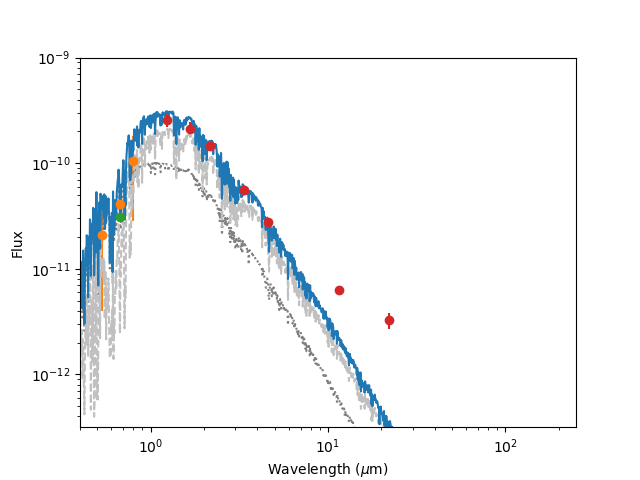

-12.5 -9.0


<IPython.core.display.Javascript object>


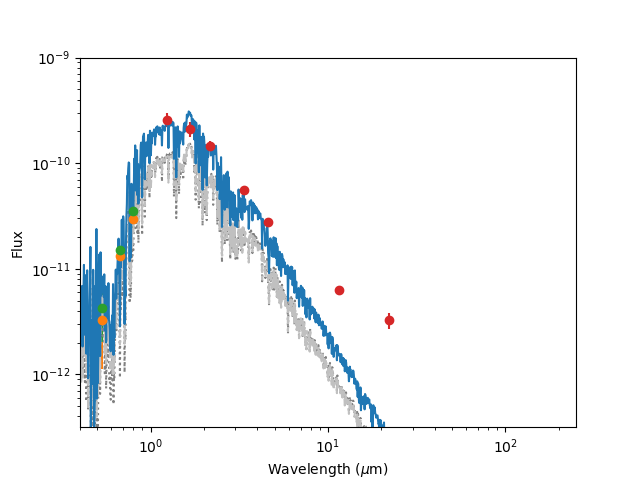

-12.5 -9.0


In [28]:
%matplotlib notebook

fig_J0949_starfit = plot_starfit_data(subj_J0949_with_stellar_fit)
fig_J0949_starfit.show()

fig_J0446_starfit = plot_starfit_data(subj_J0446_with_stellar_fit)
fig_J0446_starfit.show()

In [ ]:
print(max(subj_J0949_with_stellar_fit.nuFnu_star1_plotting_temp))

In [ ]:



teffpull1 = '0'+str(35)
loggpull1 = str(4.5)

teffpull2 = '028'
loggpull2 = str(4.5)
        
spect_file1 = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull1+'.0-'+loggpull1+'-0.0a+0.0.BT-Settl.spec.7'
spect_file2 = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull2+'.0-'+loggpull2+'-0.0a+0.0.BT-Settl.spec.7'


specX1, specS1, specdict1 = fluxdrive_plot(spect_file1, 1)
print 'specdict1 read in'
specX2, specS2, specdict2 = fluxdrive_plot(spect_file2, 1)
print 'specdict2 read in'

In [ ]:
rdstar1 = 10.**(-49.2/5.)
rdstar2 = 10.**(-48.2/5.)

modelmags2 = np.array([-34.016,-31.751,-35.431]) - 5.*np.log10(rdstar2)
modelmags1 = np.array([-35.509,-34.282,-36.648]) - 5.*np.log10(rdstar1)

modelnuFnu1 = np.array([(gaia_zps[i]*10.**(-0.4*modelmags1[i])) for i in range(3)]) * gaia_wavs_Hz * (1.0e-23)
modelnuFnu2 = np.array([(gaia_zps[i]*10.**(-0.4*modelmags2[i])) for i in range(3)]) * gaia_wavs_Hz * (1.0e-23)

#print modelnuFnu1
#print modelnuFnu2

print modelnuFnu1 - component_a_gaia_nuFnu
print modelnuFnu2 - component_b_gaia_nuFnu


fluxspecS1 = specX1 * specS1 * (rdstar1**2)
fluxspecS2 = specX2 * specS2 * (rdstar2**2)

#combined_grid = np.array(sorted([x for x in specdict1.keys() if x in specdict2.keys()]))
print 'Grid constructed'

fluxspecS1_gridded = np.interp(plotting_xvec_angstroms, specX1, fluxspecS1)
fluxspecS2_gridded = np.interp(plotting_xvec_angstroms, specX2, fluxspecS2)
combined_fluxspec = fluxspecS1_gridded + fluxspecS2_gridded

specS1_gridded = fluxspecS1_gridded / plotting_xvec_angstroms
specS2_gridded = fluxspecS2_gridded / plotting_xvec_angstroms
combined_spec = specS1_gridded + specS2_gridded

plotting_xvec_microns = plotting_xvec_angstroms * 1.0e-4

plt.figure(figsize=(8.,6.))
plt.errorbar(gaia_wavs_microns, component_a_gaia_nuFnu,yerr=3.*component_a_gaia_nuFnuerrs,fmt='.',label='component 1 Gaia')
plt.errorbar(gaia_wavs_microns, component_b_gaia_nuFnu,yerr=3.*component_b_gaia_nuFnuerrs,fmt='.', label='component 2 Gaia')
plt.errorbar(ir_wavs_microns, combined_2mass_wise_nuFnu,yerr=3.*combined_2mass_wise_nuFnuerrs,fmt='o', label='2MASS/WISE data')
plt.errorbar(apass_wavs_microns, apass_nuFnu, yerr=3.*apass_nuFnuerrs,fmt='o')
plt.plot(plotting_xvec_microns, fluxspecS1_gridded,'skyblue',linestyle='--',label='component1')
plt.plot(plotting_xvec_microns, fluxspecS2_gridded,'burlywood',linestyle='-.',label='component2')
plt.plot(plotting_xvec_microns, combined_fluxspec,'k',label='combined')
plt.plot(gaia_wavs_microns, modelnuFnu1,'o',color='skyblue')
plt.plot(gaia_wavs_microns, modelnuFnu2, 'o',color='peachpuff')
plt.xscale('log',nonposx='clip')
plt.yscale('log',nonposy='clip')
plt.xlabel(r'Wavelength ($\mu$m)',fontsize=16)
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$)',fontsize=16)
plt.xlim([0.4, 50.])
plt.ylim([1.e-13, 1.e-9])
plt.legend(loc='upper right')
#plt.show()
plt.savefig('J0949_example_two_mdwarfs.pdf')

#plt.figure(figsize=(8.,6.))
#plt.errorbar(gaia_wavs_microns, component_a_gaia_nuFnu/(gaia_wavs_microns*10000.),yerr=3.*(component_a_gaia_nuFnuerrs/(gaia_wavs_microns*10000.)),fmt='o',label='component 1')
##plt.errorbar(gaia_wavs_microns, component_b_gaia_nuFnu/(gaia_wavs_microns*10000.),yerr=3.*(component_b_gaia_nuFnuerrs/(gaia_wavs_microns*10000.)),fmt='o', label='component 2')
#plt.errorbar(ir_wavs_microns, combined_2mass_wise_nuFnu/(ir_wavs_microns*10000.),yerr=3.*combined_2mass_wise_nuFnuerrs/(ir_wavs_microns*10000.),fmt='o', label='combined')
#plt.plot(plotting_xvec_microns, specS1_gridded,'skyblue',linestyle='--',label='component1')
#plt.plot(plotting_xvec_microns, specS2_gridded,'peachpuff',linestyle='-.',label='component2')
#plt.plot(plotting_xvec_microns, combined_spec,'k',label='combined')
#plt.xscale('log',nonposx='clip')
#plt.yscale('log',nonposy='clip')
#plt.xlabel(r'Wavelength ($\mu$m)',fontsize=16)
#plt.ylabel(r'Flux Density (erg s$^{-1}$ cm$^{-2}$)',fontsize=16)
#plt.xlim([0.4, 50.])
#plt.ylim([1.e-18, 1.e-13])
#plt.legend(loc='upper right')
#plt.show()

In [ ]:
disk_blackbody = blackbody_lambda(plotting_xvec_angstroms, 270.)

disk_blackbody_nuFnu = disk_blackbody * plotting_xvec_angstroms * u.AA * np.pi * u.sr

#print disk_blackbody_nuFnu

xfactor = 1.9e-17

combined_fluxspec_final = combined_fluxspec + (xfactor * disk_blackbody_nuFnu * u.s * u.cm * u.cm / u.erg)

plt.figure(figsize=(8.,6.))

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)
      


fig, axes = plt.subplots(1,1)
plt.gcf().subplots_adjust(left = 0.18)
plt.gcf().subplots_adjust(right=0.98)
plt.gcf().subplots_adjust(top=0.97)
plt.gcf().subplots_adjust(bottom=0.14)

axes.errorbar(gaia_wavs_microns, component_a_gaia_nuFnu,yerr=3.*component_a_gaia_nuFnuerrs,fmt='o',label='component 1')
axes.errorbar(gaia_wavs_microns, component_b_gaia_nuFnu,yerr=3.*component_b_gaia_nuFnuerrs,fmt='o', label='component 2')
axes.errorbar(ir_wavs_microns, combined_2mass_wise_nuFnu,yerr=3.*combined_2mass_wise_nuFnuerrs,fmt='o', label='combined')
axes.plot(plotting_xvec_microns, fluxspecS1_gridded,'skyblue',linestyle='--')
axes.plot(plotting_xvec_microns, fluxspecS2_gridded,'burlywood',linestyle='-.')
axes.plot(plotting_xvec_microns, disk_blackbody_nuFnu*xfactor)
axes.plot(plotting_xvec_microns, combined_fluxspec_final,'k')
#plt.plot(gaia_wavs_microns, modelnuFnu1,'o',color='skyblue')
#plt.plot(gaia_wavs_microns, modelnuFnu2, 'o',color='peachpuff')
axes.set_xscale('log',nonposx='clip')
axes.set_yscale('log',nonposy='clip')
axes.set_xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=24)
axes.set_ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=24)
axes.set_xlim([0.4, 50.])
axes.set_ylim([1.e-13, 1.e-9])
lines = axes.get_lines()
legend=plt.legend(lines[0:3], ['component 1','component2','combined'],loc='upper right',fontsize=15)
legend1 = plt.legend([lines[i] for i in range(3,7)],['stellar component 1','stellar component 2','270K disk blackbody','combined'], loc='lower left', fontsize=15)
axes.add_artist(legend)
axes.add_artist(legend1)
#plt.show()
plt.savefig('AWI00063nx_two_component_model.pdf')